# CV Lab 10
# Shresht Mishra
# 211020450

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from operator import itemgetter
from collections import OrderedDict

import cv2
from torch.nn import functional as F
#from pytorch_grad_cam import GradCAM
import torch.nn.init as init

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision.utils import make_grid

#pd.options.plotting.backend = "plotly"
pd.set_option("plotting.backend", "plotly")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch.utils.data import random_split
from torch.utils.data import Subset



print("Device: ",device)

Device:  cuda


In [2]:
CSV_PATH = 'D:/CV/Dataset/sample/sample_labels.csv'

IMG_DIR = 'D:/CV/Dataset/sample/sample/images/'

In [3]:
BATCH_SIZE = 128

In [4]:
ResNet50_MODEL_PATH = 'D:/CV/Dataset/deeplabv3-master/deeplabv3-master/pretrained_models/resnet/resnet50-19c8e357.pth'

In [5]:
MODEL = ResNet50_MODEL_PATH

## EDA

In [6]:
data = pd.read_csv(CSV_PATH)
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [8]:
data['Patient Gender'].value_counts().plot.bar()

In [9]:
data['Patient Age'].apply(lambda x : int(x[1:3])).plot.hist()

In [10]:
data['Patient Age'].apply(lambda x : int(x[1:3])).plot.box()

In [11]:
data['View Position'].value_counts().plot.bar()

In [12]:
side_df = data.iloc[:,4:7]
side_df.head()

,Patient Age,Patient Gender,View Position
0,060Y,M,AP
1,057Y,M,AP
2,077Y,M,AP
3,079Y,M,PA
4,055Y,F,AP


In [13]:
side_info = ['Patient Age','Patient Gender','Patient Gender']

In [14]:
side_df['Patient Age'] = side_df['Patient Age'].str.extract('(\d+)').astype(int)

In [15]:
side_df['Patient Gender'] = side_df['Patient Gender'].replace({'M': 1, 'F': 0})

In [16]:
side_df['Patient Gender']

0       1
1       1
2       1
3       1
4       0
       ..
5601    1
5602    0
5603    0
5604    0
5605    1
Name: Patient Gender, Length: 5606, dtype: int64

In [17]:
side_df['View Position'] = side_df['View Position'].replace({'AP': 1, 'PA': 0})

In [18]:
side_df['View Position']

0       1
1       1
2       1
3       0
4       1
       ..
5601    0
5602    1
5603    0
5604    0
5605    0
Name: View Position, Length: 5606, dtype: int64

In [19]:
min_val = side_df['Patient Age'].min()
max_val = 100
side_df['Patient Age'] = side_df['Patient Age'].apply(lambda x: (x - min_val) / (max_val - min_val))

In [20]:
max_val

100

In [21]:
min_val

1

In [22]:
side_df.head()

,Patient Age,Patient Gender,View Position
0,0.595960,1,1
1,0.565657,1,1
2,0.767677,1,1
3,0.787879,1,0
4,0.545455,0,1


In [23]:
side_df['Patient Gender'] = side_df['Patient Gender'].astype('float32')

In [24]:
side_df['Patient Gender']

0       1.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
5601    1.0
5602    0.0
5603    0.0
5604    0.0
5605    1.0
Name: Patient Gender, Length: 5606, dtype: float32

In [25]:
side_df['View Position'] = side_df['View Position'].astype('float32')

In [26]:
side_df['View Position']

0       1.0
1       1.0
2       1.0
3       0.0
4       1.0
       ... 
5601    0.0
5602    1.0
5603    0.0
5604    0.0
5605    0.0
Name: View Position, Length: 5606, dtype: float32

In [27]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
    
data['No Findings'] = data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

In [28]:
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Findings
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1,0,1,0,0,0,1,0,0,0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,1
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0,1,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,0


In [29]:
data = data.drop(list(data.iloc[:,1:11].columns.values),axis = 1)
data.iloc[:,1:].sum().plot.barh()

In [30]:
data.head()

,Image Index,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Findings
0,00000013_005.png,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,00000013_026.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00000017_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,00000030_001.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,00000032_001.png,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [31]:
df_inlucding_nofindings = data

In [32]:
df_inlucding_nofindings.head()

,Image Index,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Findings
0,00000013_005.png,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,00000013_026.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00000017_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,00000030_001.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,00000032_001.png,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [33]:
data = data.drop(['No Findings'],axis = 1)
data.iloc[:,1:].sum().plot.barh()

In [34]:
data.iloc[:,1:].mean().plot.barh()

In [72]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [73]:
pos_weights_15 = freq_neg_15
neg_weights_15 = freq_pos_15
pos_contribution_15 = freq_pos_15 * pos_weights_15
neg_contribution_15 = freq_neg_15 * neg_weights_15

In [69]:
def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon=1e-7):

    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

In [70]:
def weighted_loss_15(pos_weights_15, neg_weights_15, y_pred, y_true, epsilon=1e-7):

    loss = 0.0
    for i in range(len(pos_weights_15)):
        loss_pos = -1 * torch.mean(pos_weights_15[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights_15[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

## Loading Dataset

In [39]:
data_transform = T.Compose([
    #T.RandomHorizontalFlip(),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [40]:
class NIH_Dataset(Dataset):

    def __init__(self, data, img_dir, side_df=side_df ,transform=None):
        self.data = data
        self.img_dir = img_dir 
        self.transform = transform 
        self.side_df = side_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file = self.img_dir + self.data.iloc[:,0][idx]
        img = Image.open(img_file).convert('RGB')
        label = np.array(self.data.iloc[:,1:].iloc[idx])
        side_df = np.array(self.side_df.iloc[idx])
        side_df = torch.tensor(side_df)
        side_df = side_df.float()
        side_df = side_df.reshape(-1, 3)
        side_df = side_df.squeeze(dim=1)
        side_df  =torch.squeeze(side_df,dim=1)
        


        if self.transform:
            img = self.transform(img)

        return img,label,side_df

In [41]:
trainds = NIH_Dataset(df_inlucding_nofindings,
                      img_dir = IMG_DIR,
                      side_df = side_df,
                      transform = data_transform)

In [42]:
labels = pathology_list

In [43]:
labels_15 = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia','No Findings']

In [44]:
print(labels)

['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass', 'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']


In [45]:
print(labels_15)

['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass', 'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia', 'No Findings']


In [46]:
def deprocess(img):
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img

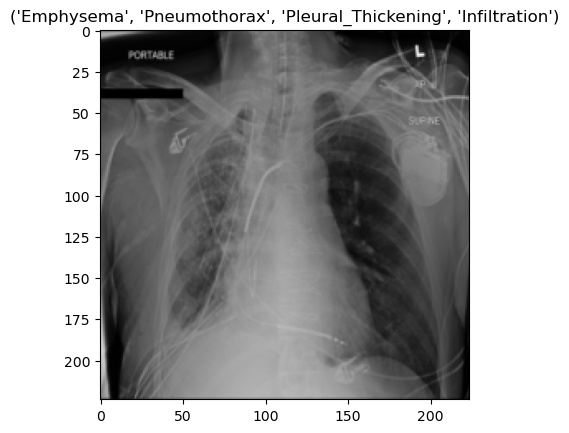

In [47]:
image, label ,sdf0 = trainds[0]
class_labels = list(np.where(label==1)[0])
plt.imshow(deprocess(image))
plt.title(itemgetter(*class_labels)(pathology_list));

In [48]:
trainds[0]

(tensor([[[-0.6794, -0.6965, -0.7137,  ..., -2.0323, -2.0323, -2.0323],
          [-0.0458, -0.0287, -0.0287,  ..., -2.0323, -2.0323, -2.0323],
          [ 0.6734,  0.7419,  0.7419,  ..., -2.0323, -2.0323, -2.0323],
          ...,
          [ 0.0569,  0.1939,  0.4679,  ..., -1.9467, -1.5357, -1.8782],
          [-0.0116,  0.2453,  0.4679,  ..., -1.7412, -1.5870, -2.0152],
          [-0.5253, -0.3198, -0.2171,  ..., -1.7069, -1.8439, -2.0665]],
 
         [[-0.5651, -0.5826, -0.6001,  ..., -1.9482, -1.9482, -1.9482],
          [ 0.0826,  0.1001,  0.1001,  ..., -1.9482, -1.9482, -1.9482],
          [ 0.8179,  0.8880,  0.8880,  ..., -1.9482, -1.9482, -1.9482],
          ...,
          [ 0.1877,  0.3277,  0.6078,  ..., -1.8606, -1.4405, -1.7906],
          [ 0.1176,  0.3803,  0.6078,  ..., -1.6506, -1.4930, -1.9307],
          [-0.4076, -0.1975, -0.0924,  ..., -1.6155, -1.7556, -1.9832]],
 
         [[-0.3404, -0.3578, -0.3753,  ..., -1.7173, -1.7173, -1.7173],
          [ 0.3045,  0.3219,

## Spliting dataset

In [49]:
trainset, validset, testset = random_split(trainds, [4000,603,1003])

print("Length of trainset : {}".format(len(trainset)))
print("Length of testset : {}".format(len(testset)))
print("Length of validset : {}".format(len(validset)))

Length of trainset : 4000
Length of testset : 1003
Length of validset : 603


In [50]:
df_inlucding_nofindings.head()

,Image Index,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Findings
0,00000013_005.png,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,00000013_026.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00000017_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,00000030_001.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,00000032_001.png,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [51]:
trainloader = DataLoader(trainset,
                         batch_size = BATCH_SIZE,
                         shuffle = True)

validloader = DataLoader(validset,
                         batch_size = BATCH_SIZE,
                         shuffle = False)

testloader = DataLoader(testset,
                        batch_size = BATCH_SIZE,
                        shuffle = False)

## Defining Pre trained model

In [52]:
from torchvision import models

In [53]:
res_branch = models.resnet50()
res_branch.load_state_dict(torch.load(ResNet50_MODEL_PATH))

<All keys matched successfully>

In [54]:
res_branch_backbone = nn.Sequential(*list(res_branch.children())[:-1])

In [55]:
res_branch_backbone.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [56]:
test_image,test_label,test_side_df = testset[33]

test_res_branch = res_branch_backbone( test_image.unsqueeze(0).to(device)  )

In [57]:
test_res_branch

tensor([[[[0.3624]],

         [[0.6516]],

         [[0.4309]],

         ...,

         [[0.3586]],

         [[0.4737]],

         [[0.3475]]]], device='cuda:0', grad_fn=<MeanBackward1>)

In [58]:
test_res_branch.shape

torch.Size([1, 2048, 1, 1])

In [59]:
test_res_branch.dtype

torch.float32

In [60]:
tensor_1x2048 =  test_res_branch.view(test_res_branch.size(0), -1)

In [61]:
tensor_1x2048.shape

torch.Size([1, 2048])

In [62]:
test_side_df.shape

torch.Size([1, 3])

In [63]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()

        resnet = models.resnet50()
        resnet.load_state_dict(torch.load(MODEL))
        for param in resnet.parameters():
            param.requires_grad = False
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        self.fc = nn.Sequential(nn.Linear(2051, 14),
                                nn.Sigmoid()
                                )

        init.xavier_uniform_(self.fc[0].weight)

        self.fc[0].bias.data.fill_(0)

        
    
    
    def forward(self, x,y):

        x = self.backbone(x)       
        x = x.view(x.size(0), -1)
        y  = torch.squeeze(y,dim=1)
        concat_x_y = torch.cat([x,y],dim=1)

        concat_x_y = concat_x_y.view(concat_x_y.size(0), -1)

        concat_x_y = self.fc(concat_x_y)
        
        return concat_x_y

## Training Model

In [64]:
model = CustomNet()

In [65]:
model.to(device)

CustomNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [77]:
Learning_Rate = 0.001

In [78]:
optimizer = optim.Adam(model.parameters(),
                        lr = Learning_Rate)

epochs = 10
valid_loss_min = np.Inf

In [79]:
for i in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    test_loss = 0.0
    
    train_acc = 0.0
    valid_acc = 0.0 
    test_acc = 0.0

    model.train()
    for images,labels,side_df in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        side_df = side_df.to(device)

        ps = model(images,side_df)
        loss = weighted_loss(pos_weights,neg_weights,ps,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train_loss = train_loss / len(trainloader)

    model.eval()
    with torch.no_grad():
        for images,labels,side_df in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)
            side_df = side_df.to(device)

            ps = model(images,side_df)
            loss = weighted_loss(pos_weights, neg_weights,ps,labels)
            valid_loss += loss.item()
    
    
        avg_valid_loss = valid_loss / len(validloader)
        
    with torch.no_grad():
        for images,labels,side_df in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            side_df = side_df.to(device)

            ps = model(images,side_df)
            loss = weighted_loss(pos_weights, neg_weights,ps,labels)
            test_loss += loss.item()
    
    
        avg_test_loss = test_loss / len(testloader)
        
    #schedular.step(avg_valid_loss)
    #no learning rate ddecay in warmin_up

    if avg_valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
        torch.save(model,'Res50_best.pt')
            
        valid_loss_min = avg_valid_loss


    
    print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    print("Epoch : {} Valid Loss : {:.6f} ".format(i+1,avg_valid_loss))
    print("Epoch : {} TestLoss : {:.6f} ".format(i+1,avg_test_loss))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.71s/it]


Validation loss decreased (inf --> 0.889590).   Saving model ...
Epoch : 1 Train Loss : 0.886505 
Epoch : 1 Valid Loss : 0.889590 
Epoch : 1 TestLoss : 0.867419 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.73s/it]


Validation loss decreased (0.889590 --> 0.858828).   Saving model ...
Epoch : 2 Train Loss : 0.833946 
Epoch : 2 Valid Loss : 0.858828 
Epoch : 2 TestLoss : 0.831035 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.73s/it]


Epoch : 3 Train Loss : 0.807192 
Epoch : 3 Valid Loss : 0.861266 
Epoch : 3 TestLoss : 0.845538 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.66s/it]


Validation loss decreased (0.858828 --> 0.855069).   Saving model ...
Epoch : 4 Train Loss : 0.801868 
Epoch : 4 Valid Loss : 0.855069 
Epoch : 4 TestLoss : 0.829292 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.61s/it]


Validation loss decreased (0.855069 --> 0.851587).   Saving model ...
Epoch : 5 Train Loss : 0.770935 
Epoch : 5 Valid Loss : 0.851587 
Epoch : 5 TestLoss : 0.828151 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.69s/it]


Epoch : 6 Train Loss : 0.763133 
Epoch : 6 Valid Loss : 0.867379 
Epoch : 6 TestLoss : 0.837177 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.65s/it]


Validation loss decreased (0.851587 --> 0.851381).   Saving model ...
Epoch : 7 Train Loss : 0.762712 
Epoch : 7 Valid Loss : 0.851381 
Epoch : 7 TestLoss : 0.823466 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.75s/it]


Epoch : 8 Train Loss : 0.740339 
Epoch : 8 Valid Loss : 0.868117 
Epoch : 8 TestLoss : 0.840976 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.64s/it]


Validation loss decreased (0.851381 --> 0.843418).   Saving model ...
Epoch : 9 Train Loss : 0.731282 
Epoch : 9 Valid Loss : 0.843418 
Epoch : 9 TestLoss : 0.816038 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.64s/it]

Epoch : 10 Train Loss : 0.723301 
Epoch : 10 Valid Loss : 0.847258 
Epoch : 10 TestLoss : 0.814193 


## Each class accuracy

In [80]:
def class_accuracy(dataloader, model):

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0

    with torch.no_grad():
        for images,labels,side_df in dataloader:
            side_df = side_df.to(device)
            ps = model(images.to(device), side_df)
            labels = labels.to(device)
            
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(dataloader.dataset))*100.0 for i in per_class_accuracy]

    return per_class_accuracy     


def get_acc_data(class_names,acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Acc']) 
    return df 

In [81]:
def class_accuracy_15(dataloader, model):

    per_class_accuracy = [0 for i in range(len(df_inlucding_nofindings))]
    total = 0.0

    with torch.no_grad():
        for images,labels,side_df in dataloader:
            side_df = side_df.to(device)
            ps = model(images.to(device), side_df)
            labels = labels.to(device)
            
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(dataloader.dataset))*100.0 for i in per_class_accuracy]

    return per_class_accuracy     


def get_acc_data(class_names,acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Acc']) 
    return df

In [82]:
print("Train Dataset Accuracy Report")
acc_list = class_accuracy(trainloader, model)
get_acc_data(pathology_list,acc_list)

Train Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,61.600
1,Emphysema,79.650
2,Effusion,63.475
3,Hernia,96.350
4,Nodule,71.850
5,Pneumothorax,70.550
6,Atelectasis,69.950
7,Pleural_Thickening,78.725
8,Mass,69.250
9,Edema,66.525


In [83]:
print("Test Dataset Accuracy Report")
acc_list = class_accuracy(testloader, model)
get_acc_data(pathology_list,acc_list)

Test Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,61.515454
1,Emphysema,79.361914
2,Effusion,61.116650
3,Hernia,95.613161
4,Nodule,71.086740
5,Pneumothorax,67.597208
6,Atelectasis,68.693918
7,Pleural_Thickening,76.271186
8,Mass,66.001994
9,Edema,66.101695


In [84]:
print("Valid Dataset Accuracy Report")
acc_list = class_accuracy(validloader, model)
get_acc_data(pathology_list,acc_list)

Valid Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,59.203980
1,Emphysema,78.109453
2,Effusion,59.867330
3,Hernia,95.356551
4,Nodule,69.485904
5,Pneumothorax,67.827529
6,Atelectasis,66.169154
7,Pleural_Thickening,75.621891
8,Mass,65.174129
9,Edema,65.008292


In [85]:
from sklearn.metrics import roc_auc_score, roc_curve

In [86]:
def get_roc_curve(labels, preds, class_names):
    plt.figure(figsize=(15,10))
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    for i in range(len(class_names)):
        fpr, tpr, thresholds = roc_curve(labels[:,i], preds[:,i])
        plt.plot(fpr, tpr, label = class_names[i])
    plt.legend(loc='best')
    plt.show()

In [87]:
def get_roc_auc_score(labels, preds):
    roc_auc_scores = []
    for i in range(len(pathology_list)):
        roc_auc_scores.append(roc_auc_score(labels[:,i], preds[:,i]))
    return roc_auc_scores

In [88]:
def get_roc_auc_data(class_names,roc_auc_scores):
    df = pd.DataFrame(list(zip(class_names, roc_auc_scores)), columns =['Labels', 'ROC AUC Score']) 
    return df

def get_roc_data(labels, preds, class_names):
    get_roc_curve(labels, preds, class_names)
    roc_auc_scores = get_roc_auc_score(labels, preds)
    return get_roc_auc_data(class_names,roc_auc_scores)

In [89]:
def get_roc_data_for_dataset(dataloader, model, class_names):
    labels = []
    preds = []
    with torch.no_grad():
        for images,labels_batch,side_df in dataloader:
            labels_batch = labels_batch.numpy()
            labels.append(labels_batch)
            side_df = side_df.to(device)
            ps = model(images.to(device),side_df)
            ps = ps.cpu().numpy()
            preds.append(ps)
    labels = np.concatenate(labels)
    preds = np.concatenate(preds)
    return get_roc_data(labels, preds, class_names)

Train Dataset ROC AUC Report


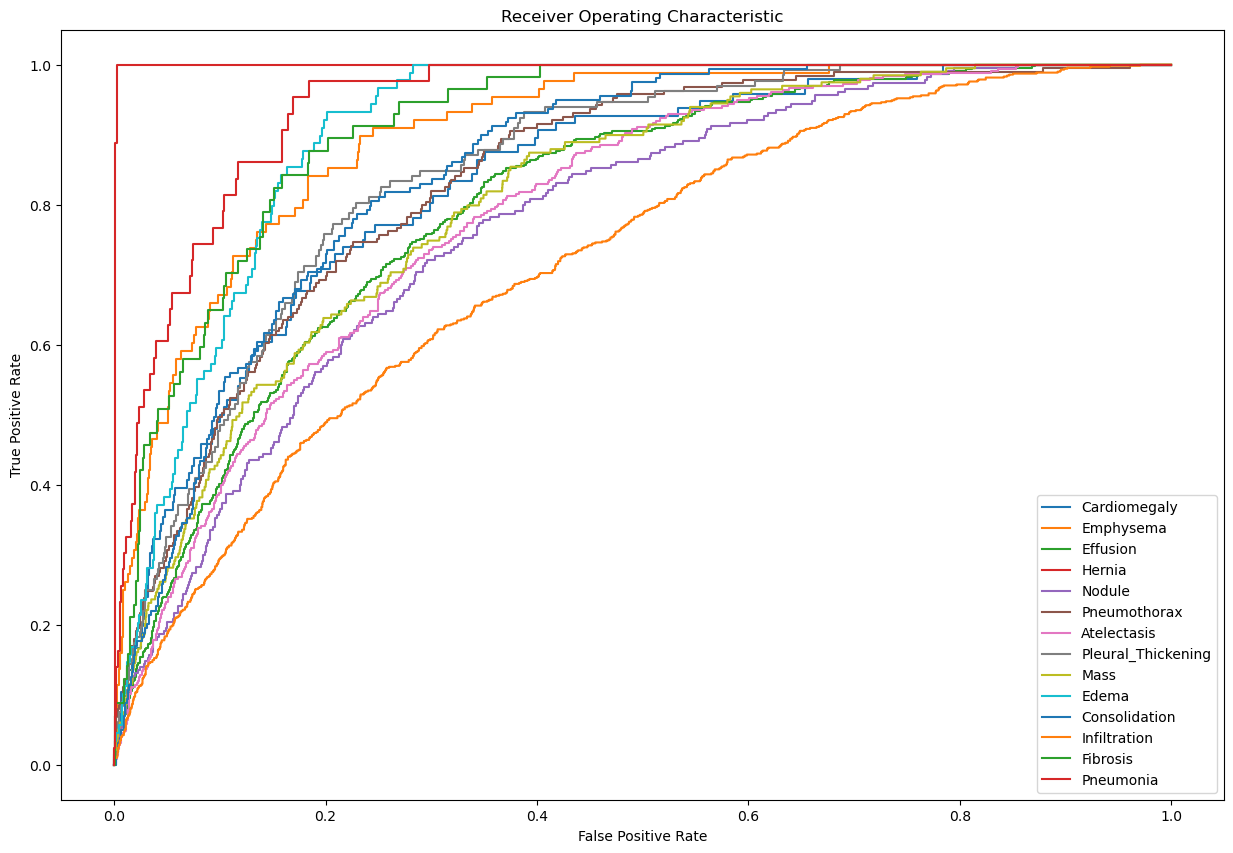

,Labels,ROC AUC Score
0,Cardiomegaly,0.835417
1,Emphysema,0.903546
2,Effusion,0.805126
3,Hernia,0.999471
4,Nodule,0.773530
5,Pneumothorax,0.838121
6,Atelectasis,0.791617
7,Pleural_Thickening,0.849823
8,Mass,0.808801
9,Edema,0.910135


In [90]:
print("Train Dataset ROC AUC Report")
get_roc_data_for_dataset(trainloader, model, pathology_list)

Test Dataset ROC AUC Report


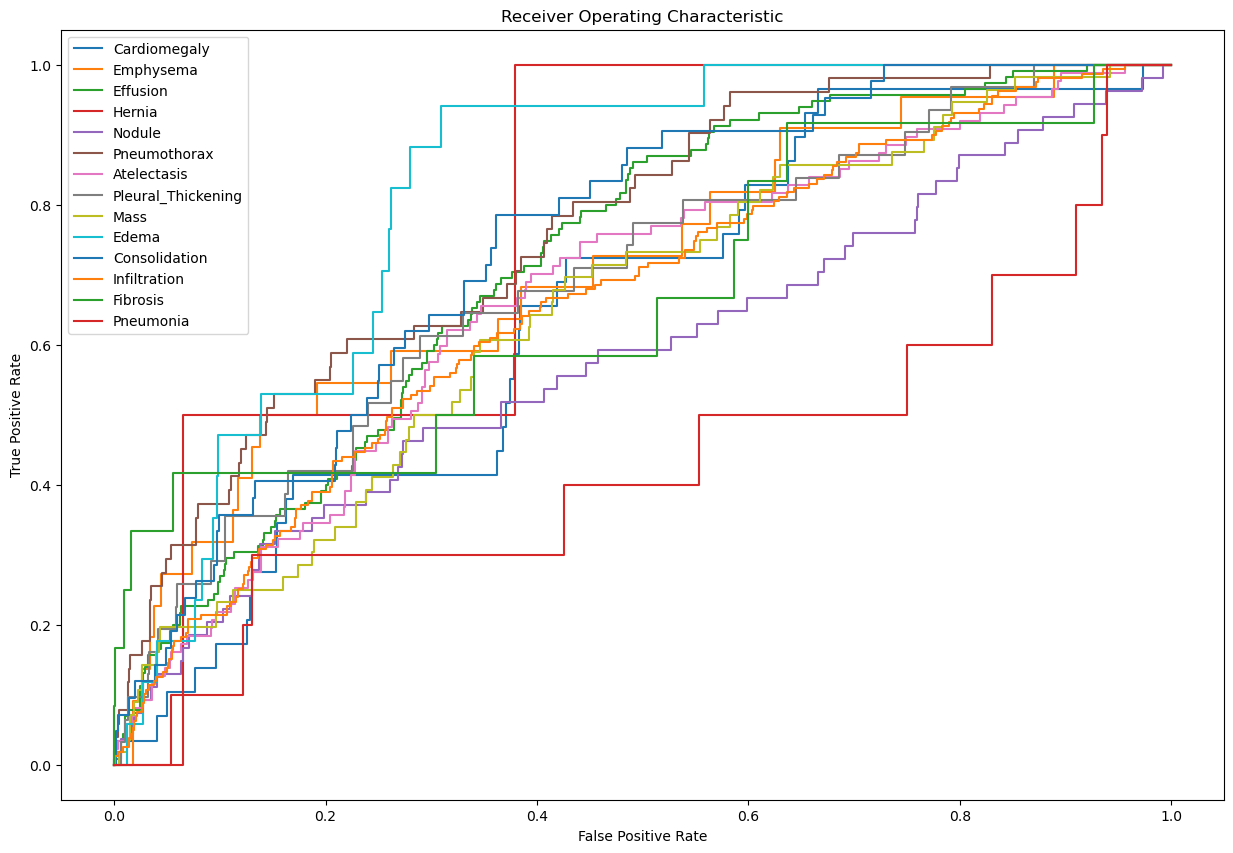

,Labels,ROC AUC Score
0,Cardiomegaly,0.651986
1,Emphysema,0.709526
2,Effusion,0.719751
3,Hernia,0.777722
4,Nodule,0.584475
5,Pneumothorax,0.764047
6,Atelectasis,0.670218
7,Pleural_Thickening,0.691192
8,Mass,0.653021
9,Edema,0.820010


In [91]:
print("Test Dataset ROC AUC Report")
get_roc_data_for_dataset(testloader, model, pathology_list)

Valid Dataset ROC AUC Report


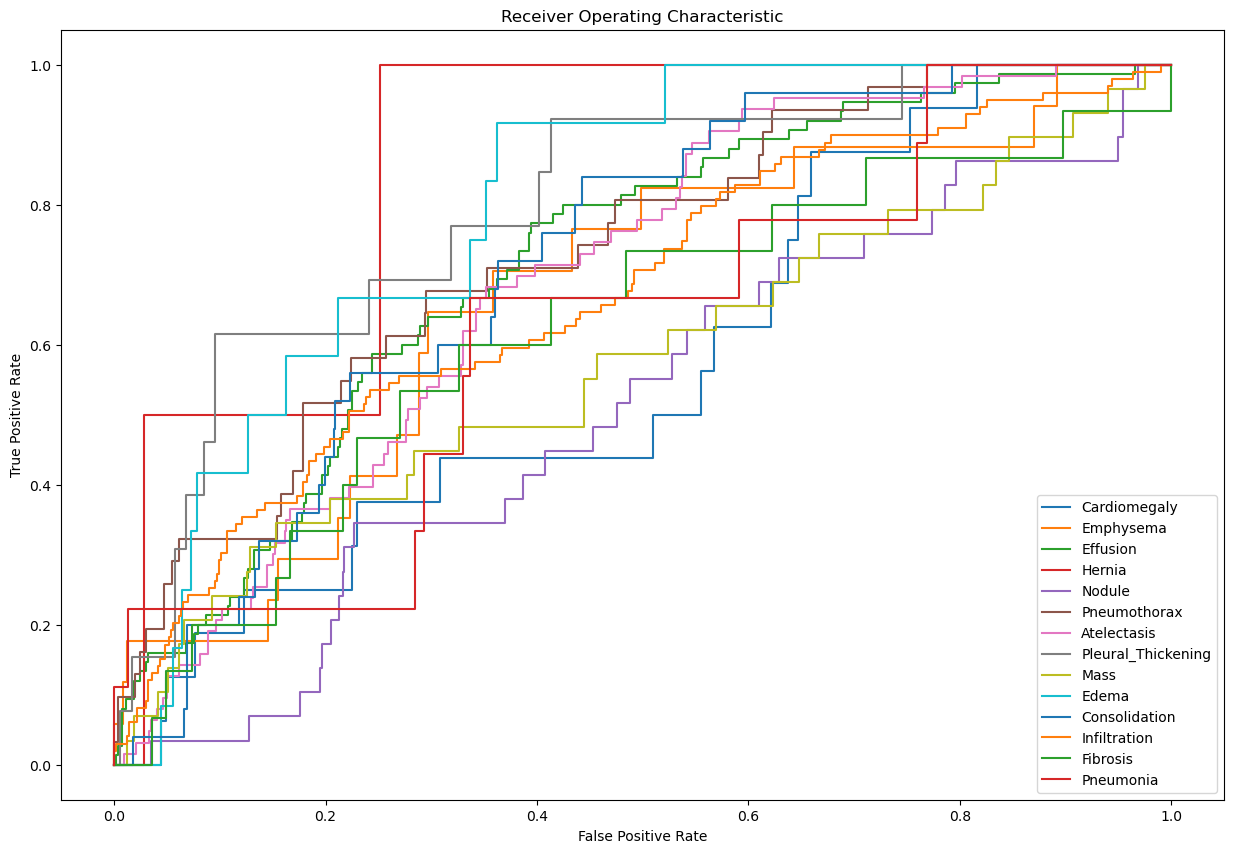

,Labels,ROC AUC Score
0,Cardiomegaly,0.573573
1,Emphysema,0.670950
2,Effusion,0.718005
3,Hernia,0.860233
4,Nodule,0.512135
5,Pneumothorax,0.734435
6,Atelectasis,0.694944
7,Pleural_Thickening,0.800000
8,Mass,0.576595
9,Edema,0.801043


In [92]:
print("Valid Dataset ROC AUC Report")
get_roc_data_for_dataset(validloader, model, pathology_list)